In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import glob
import os
import sys

from tqdm.notebook import tqdm
from datetime import datetime

import Cross_Eval

In [3]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from sklearn.kernel_approximation import RBFSampler, Nystroem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold, KFold

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.multiclass import OneVsRestClassifier

from mlxtend.evaluate import scoring

# Preparing Metadata/Labels

In [4]:
all_files = pd.DataFrame(glob.glob("/mnt/d/Conor/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])
all_files["TMA"] = all_files.apply(lambda row: float(row["hdf_loc"].split("/")[-1][4:5]), axis = 1)
all_files["Core"] = all_files.apply(lambda row: row["hdf_loc"].split("/")[-1][8:-7], axis = 1)

In [5]:
metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx"
              , sheet_name = "reformatted")

metadata = metadata.merge(all_files, left_on = ["TMA", "TMA site"], right_on = ["TMA", "Core"])
print(metadata.shape)

(79, 18)


In [6]:
new_metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/new_metadata.xlsx")

In [7]:
new_metadata["DODvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "DOD",
                             "alive": "Other",
                             "died other" : "Other",
                             "died" : "Other",
                             "Died" : "Other",
                             "Died other": "Other"})

new_metadata["DiedvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "Died",
                             "alive": "Alive",
                             "died other" : "Died",
                             "died" : "Died",
                             "Died" : "Died",
                             "Died other": "Died"})

In [8]:
new_metadata['lifespan'] = new_metadata['Date of death'] - new_metadata['date of diag']

new_metadata["2year"] = new_metadata['lifespan'].dt.days < 730
new_metadata["5year"] = new_metadata['lifespan'].dt.days < 1825

In [9]:
new_metadata["2year"] = new_metadata.apply(lambda row: True if (row['Date of death']-row['date of diag']).days<730 and row.OUTCOME!='Alive' else False, axis = 1)
new_metadata["5year"] = new_metadata.apply(lambda row: True if 730<(row['Date of death']-row['date of diag']).days<1825 and row.OUTCOME!='Alive' else False, axis = 1)

new_metadata["Alive"] = new_metadata.apply(lambda row: True if 730<(row['Last seen/reviewed']-row['date of diag']).days<1825 and row.OUTCOME=='Alive' else False, axis = 1)

# Import data and preprocess

In [10]:
from Preprocessing_Methods import *

import sys

sys.path.append("/mnt/b/Git_Projects/Biospec_Analysis/UNET")

select = ['Tumour']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue in {select}").sample(frac = 1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

In [35]:
select = ['Paraffin', "Outer", "Inner"]

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).sample(frac = 1).query(f"Tissue not in {select}"), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

In [42]:
total = total.reset_index().merge(new_metadata.loc[:, ["Patient_Number", "OUTCOME", "DODvsAlive", "DiedvsAlive", 'lifespan', "2year", "5year"]], left_on = "Patient nu ", right_on = "Patient_Number", how = 'inner')
total["TvsN"] = total.reset_index()["Tissue"].map({"Tumour": "Tumour"}).fillna("Normal Tissue")
total = total.set_index(list(total.columns.difference(wn_cols))).dropna(axis = 1)

In [43]:
total.reset_index()["TvsN"].value_counts()

Normal Tissue    1242017
Tumour            299607
Name: TvsN, dtype: int64

In [44]:
total.sample(10)

1002.0  \
2year 2year_x 2year_y 5year 5year_x 5year_y Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive DODvsAlive_x DODvsAlive_y Diagnosis Age DiedvsAlive DiedvsAlive_x DiedvsAlive_y ECS ID      N stage OUTCOME    OUTCOME_x  OUTCOME_y  Overall Death  Pathogical Stage Patient nu  Patient_Number Patient_Number_x Patient_Number_y T stage TMA TMA site Tissue      TvsN          advancing front type diff   envi_loc                                           gender lifespan lifespan_x lifespan_y radiotherapy recurrence survival (months)             
True  True    True    False False   False   /mnt/b/Google_Drive/PhD/Project with Janet/Labe... C7     C7     oral tongue              Other      Other        Other        89.0          Died        Died          Died          no  2.0-C7  0       died other died other died other yes            pT2N0M0          3529        3529           3529             3529             2       2.0 C7       Blood       Normal Tissue non-cohesive         poorly /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      265 days 265 days   265 days   no           NaN        18.0               0.083008   
                                                                                                                                                                                                                                                                                                                                                                                                        Muscle      Normal Tissue non-cohesive         poorly /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      265 days 265 days   265 days   no           NaN        18.0               0.051928   
                                            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... F13    F13    other                    DOD        DOD          DOD          71.0          Died        Died          Died          no  2.0-F13 0       DOD        DOD        DOD        Yes            pT4aN0Mx         3486        3486           3486             3486             4a      2.0 F13      Desmoplasia Normal Tissue non-cohesive         poorly /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      174 days 174 days   174 days   NaN          yes 09     6.0                0.053476   
                                            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... B8     B8     FOM                      Other      Other        Other        74.0          Died        Died          Died          yes 2.0-B8  2c      died other died other died other yes            pT2N2cMx         3568        3568           3568             3568             2       2.0 B8       Desmoplasia Normal Tissue NaN                  NaN    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      44 days  44 days    44 days    no           no         1.0                0.060783   
                                            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... C6     C6     other                    DOD        DOD          DOD          70.0          Died        Died          Died          yes 2.0-C6  2b      DOD        DOD        DOD        yes            pT2N2b           3507        3507           3507             3507             2       2.0 C6       Stroma      Normal Tissue non-cohesive         mod    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      483 days 483 days   483 days   yes          yes        16.0               0.014614   
                                            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... D5     D5     oral tongue              DOD        DOD          DOD          80.0          Died        Died          Died          yes 2.0-D5  1       DOD        DOD        DOD        yes            pT4N1M0          3541        3541           3541             3541             4       2.0 D5       Adiopocytes Normal Tissue islands              mod    /mnt

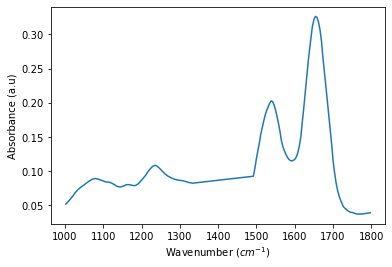

In [19]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.mean(axis = 0).T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
fig.savefig(os.getcwd()+ "/Plots/Mean_Spectra.png", bbox_inches = 'tight')

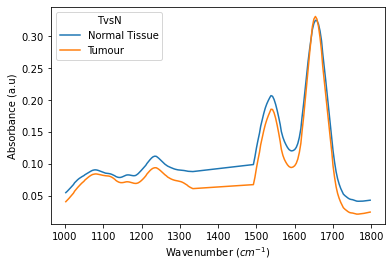

In [45]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.groupby("TvsN").mean().T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
fig.savefig(os.getcwd()+ "/Plots/Mean_ECS_Spectra.png", bbox_inches = 'tight')

In [22]:
pcapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA())
])

In [47]:
n = total.reset_index()["Patient_Number"].value_counts().min()
total_ = total.groupby("Patient_Number", group_keys=False).apply(lambda g: g.sample(n))

In [48]:
total_.head()

1002.0  \
2year 2year_x 2year_y 5year 5year_x 5year_y Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive DODvsAlive_x DODvsAlive_y Diagnosis Age DiedvsAlive DiedvsAlive_x DiedvsAlive_y ECS ID     N stage OUTCOME OUTCOME_x OUTCOME_y Overall Death  Pathogical Stage Patient nu  Patient_Number Patient_Number_x Patient_Number_y T stage TMA TMA site Tissue TvsN          advancing front type diff envi_loc                                           gender lifespan  lifespan_x lifespan_y radiotherapy recurrence survival (months)             
False False   False   False False   False   /mnt/b/Google_Drive/PhD/Project with Janet/Labe... F1     F1     FOM                      DOD        DOD          DOD          58.0          Died        Died          Died          no  2.0-F1 0       DOD     DOD       DOD       yes            pT4N0            3143        3143           3143             3143             4       2.0 F1       Blood  Normal Tissue islands              mod  /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      3341 days 3341 days  3341 days  yes          yes        111.0              0.103386   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   111.0              0.105612   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   111.0              0.104063   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   111.0              0.093782   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   111.0              0.111208   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [49]:
total_.reset_index()["N stage"].value_counts()

0     19860
2b    17874
1     11916
2c     3972
2a      993
Name: N stage, dtype: int64

In [50]:
pd.crosstab(total.reset_index()["DODvsAlive"], total.reset_index()["N stage"])

N stage,0,1,2a,2b,2c
DODvsAlive,,,,,
DOD,104664,118225,0,141670,67647
Other,400979,249398,38034,343009,46090


In [51]:
total.index.names

FrozenList(['2year', '2year_x', '2year_y', '5year', '5year_x', '5year_y', 'Annotation_loc', 'Core_x', 'Core_y', 'Corrected Site AJCC/UICC', 'DODvsAlive', 'DODvsAlive_x', 'DODvsAlive_y', 'Diagnosis Age', 'DiedvsAlive', 'DiedvsAlive_x', 'DiedvsAlive_y', 'ECS', 'ID', 'N stage', 'OUTCOME', 'OUTCOME_x', 'OUTCOME_y', 'Overall Death ', 'Pathogical Stage', 'Patient nu ', 'Patient_Number', 'Patient_Number_x', 'Patient_Number_y', 'T stage', 'TMA', 'TMA site', 'Tissue', 'TvsN', 'advancing front type', 'diff', 'envi_loc', 'gender', 'lifespan', 'lifespan_x', 'lifespan_y', 'radiotherapy', 'recurrence', 'survival (months)'])

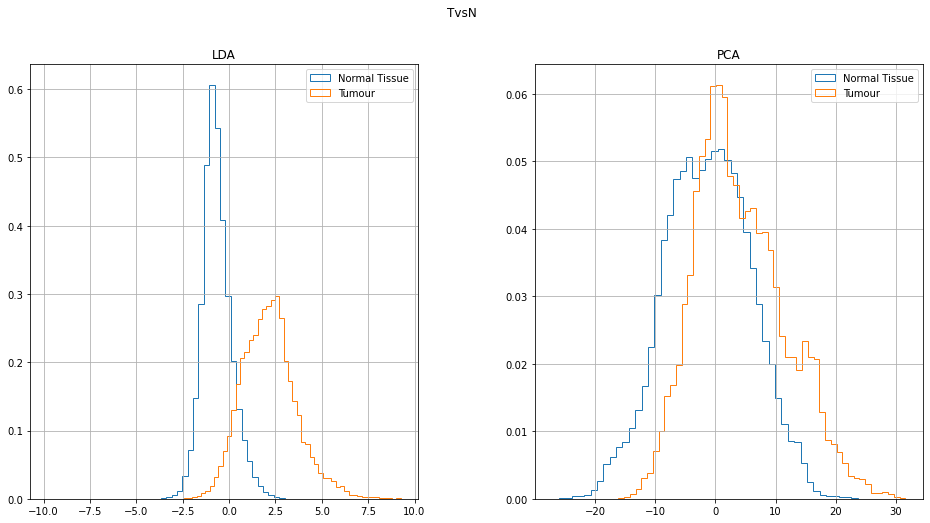

In [52]:
y = "TvsN"

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16,8))
fig.suptitle(y)

data = total_.copy().sample(frac = 1)#.drop(np.nan, level = "DODvsAlive")

total_lda = pd.DataFrame(
    LinearDiscriminantAnalysis(n_components = 1).fit_transform(pcapipe.fit_transform(data), data.reset_index()[f"{y}"].values)
    , index = data.index)


for name, df in total_lda.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax1, histtype = 'step', label = name, density = True)

ax1.set_title("LDA")
ax1.legend()
    
total_pca = pd.DataFrame(
    PCA(n_components = 1).fit_transform(pcapipe.fit_transform(data), data.reset_index()[f"{y}"])
    , index = data.index)


for name, df in total_pca.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax2, histtype = 'step', label = name, density = True)

ax2.set_title("PCA")
plt.legend()

# Breast Cancer Data

In [103]:
breast_DF = truncate(pd.read_pickle("/mnt/b/Google_Drive/PhD/DataSets/BRC961.pickle"))
index = list(breast_DF.index.names)
index.append("TvsN")

In [105]:
test = breast_DF.reset_index()

test.loc[(test["Type"] == "malignant") & (test["Label"] == "epith"), "TvsN"] = "Tumour"
test["TvsN"] = test["TvsN"].fillna("Normal")

breast_DF = test.set_index(index)
#test.loc[test["Type"] == "malignant" and test["Label"] == "epith", "TvsN"] = "Normal"

In [86]:
breast_DF.reset_index()["Label"].value_counts()

myo         162065
epith        82275
coll         81546
necrosis     44727
fibro        39201
lymph        12722
blood         1139
Name: Label, dtype: int64

In [59]:
breast_DF.reset_index()["Type"].value_counts()

malignant      144485
In Situ         99438
hyperplasia     73129
benign          43180
sarcoma         42829
normal          20614
Name: Type, dtype: int64

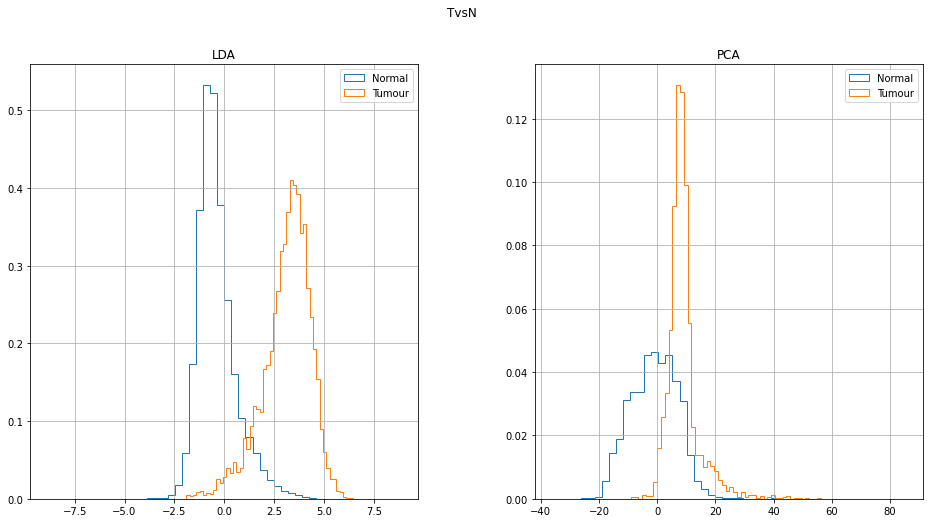

In [108]:
y = "TvsN"

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16,8))
fig.suptitle(y)

breast_data = breast_DF.copy().sample(frac = 0.1)#.drop(np.nan, level = "DODvsAlive")

total_lda = pd.DataFrame(
    LinearDiscriminantAnalysis(n_components = 1).fit_transform(pcapipe.fit_transform(breast_data), breast_data.reset_index()[f"{y}"].values)
    , index = breast_data.index)


for name, df in total_lda.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax1, histtype = 'step', label = name, density = True)

ax1.set_title("LDA")
ax1.legend()
    
total_pca = pd.DataFrame(
    PCA(n_components = 1).fit_transform(pcapipe.fit_transform(breast_data), breast_data.reset_index()[f"{y}"])
    , index = breast_data.index)


for name, df in total_pca.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax2, histtype = 'step', label = name, density = True)

ax2.set_title("PCA")
plt.legend()

In [109]:
ldapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA()),
    ("clf", LinearDiscriminantAnalysis())
])

In [118]:
total.sample(5)

1002.0  \
2year 2year_x 2year_y 5year 5year_x 5year_y Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive DODvsAlive_x DODvsAlive_y Diagnosis Age DiedvsAlive DiedvsAlive_x DiedvsAlive_y ECS ID      N stage OUTCOME OUTCOME_x OUTCOME_y Overall Death  Pathogical Stage Patient nu  Patient_Number Patient_Number_x Patient_Number_y T stage TMA TMA site Tissue         TvsN          advancing front type diff   envi_loc                                           gender lifespan lifespan_x lifespan_y radiotherapy recurrence      survival (months)             
False False   False   False False   False   /mnt/b/Google_Drive/PhD/Project with Janet/Labe... A1     A1     oropharynx               Other      Other        Other        60.0          Alive       Alive         Alive         no  2.0-A1  1       alive   alive     alive     no             pT2N1Mx          3481        3481           3481             3481             2       2.0 A1       Desmoplasia    Normal Tissue non cohesive type 4  poorly /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      NaT      NaT        NaT        yes          yes (06-tongue) 91.0               0.023214   
True  True    True    False False   False   /mnt/b/Google_Drive/PhD/Project with Janet/Labe... H11    H11    oral tongue              DOD        DOD          DOD          52.0          Died        Died          Died          yes 2.0-H11 2b      DOD     DOD       DOD       yes            pT3N2bM0         3484        3484           3484             3484             3       2.0 H11      Inflamed       Normal Tissue island               mod    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      310 days 310 days   310 days   Yes          yes             12.0               0.017493   
False False   False   False False   False   /mnt/b/Google_Drive/PhD/Project with Janet/Labe... A9     A9     other                    Other      Other        Other        44.0          Alive       Alive         Alive         yes 1.0-A9  2b      alive   alive     alive     no             pT4N2bMx         3578        3578           3578             3578             4       1.0 A9       Salivary Gland Normal Tissue NaN                  NaN    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      NaT      NaT        NaT        NaN          NaN             90.0              -0.002417   
                                            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... D3     D3     other                    Other      Other        Other        44.0          Alive       Alive         Alive         yes 2.0-D3  2b      alive   alive     alive     no             pT4N2bMx         3578        3578           3578             3578             4       2.0 D3       Salivary Gland Normal Tissue NaN                  NaN    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      NaT      NaT        NaT        NaN          NaN             90.0               0.070870   
True  True    True    False False   False   /mnt/b/Google_Drive/PhD/Project with Janet/Labe... C9     C9     FOM                      Other      Other        Other        64.0          Died        Died          Died          no  2.0-C9  1       died    died      died      yes            pT2N1Mx          3531        3531           3531             3531             2       2.0 C9       Stroma         Normal Tissue non-cohesive         mod    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      265 days 265 days   265 days   yes          no              9.0                0.048506   

                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [125]:
common_cols = np.intersect1d(breast_DF.columns, total.columns)

In [117]:
breast_DF.sample(5)

,,,,,,,,,,,,,,,,,,,1000.0,1002.0,1004.0,1006.0,1008.0,1010.0,1012.0,1014.0,1016.0,1018.0,...,1780.0,1782.0,1784.0,1786.0,1788.0,1790.0,1792.0,1794.0,1796.0,1798.0
Core,Label,No.,Age,Sex,Organ,Pathology,TNM,Grade,Stage,Type,Tissue ID.,AR,ER,PR,HER2,Region Label,TMA,TvsN,,,,,,,,,,,,,,,,,,,,,
A11,myo,11,16,F,breast,Fibroadenoma,-,0,-,benign,F06-1706,"+, 50%","++~+++, 80%","++~+++, 80%",+-,217,BRC961,Normal,0.025622,0.025734,0.024590,0.025000,0.025977,0.026223,0.026831,0.028250,0.029431,0.030077,...,0.020883,0.021942,0.021330,0.020625,0.020157,0.018807,0.017660,0.018031,0.018244,0.018282
F1,myo,61,31,F,breast,Invasive ductal carcinoma,T2N0M0,II~III,-,malignant,F06-0901,+-,-,-,+++,931,BRC961,Normal,0.028711,0.029334,0.029839,0.030667,0.032193,0.033774,0.035434,0.036978,0.037272,0.038066,...,0.025490,0.024650,0.023494,0.024179,0.024763,0.023207,0.022653,0.024755,0.025557,0.024668
C11,myo,35,41,F,breast,Invasive ductal carcinoma,T3N2M0,II,-,malignant,F06-0881,-,"+, 5%",-,+++,653,BRC961,Normal,0.029638,0.030583,0.032312,0.033295,0.032573,0.032344,0.033574,0.036224,0.038868,0.040037,...,0.027749,0.026320,0.025972,0.027151,0.027093,0.026434,0.026203,0.026600,0.026547,0.027407
C12,fibro,36,18,F,breast,Invasive ductal carcinoma,T2N0M0,II~III,-,malignant,F06-0895,+-,"+~++, 5%","+~++, 5%",+,640,BRC961,Normal,0.034987,0.036529,0.038357,0.040192,0.041062,0.041223,0.041538,0.042717,0.043817,0.044197,...,0.033004,0.033904,0.034156,0.034645,0.035243,0.035725,0.035079,0.034311,0.034999,0.036465
C4,lymph,28,37,F,breast,Invasive ductal carcinoma (partially intraductal carcinoma),T3N1M1,I~II,-,In Situ,F06-0021,"+~++, 20%","++~+++, 60%","++~+++, 50%",+,637,BRC961,Normal,0.046399,0.047608,0.049844,0.051687,0.052794,0.053798,0.055220,0.056738,0.058085,0.060439,...,0.043362,0.042700,0.043660,0.045006,0.045239,0.045282,0.045782,0.046142,0.046381,0.046976


In [139]:
from sklearn.preprocessing import LabelBinarizer

In [141]:
lb = LabelBinarizer()
lb.fit(breast_DF.reset_index()["TvsN"])

LabelBinarizer()

In [147]:
ldapipe.fit(breast_DF.loc[:, common_cols], lb.transform(breast_DF.reset_index()["TvsN"]))

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Pipeline(steps=[('Normalise spectra',
                 FunctionTransformer(func=<function robust_scale at 0x7f7e6229d550>,
                                     kw_args={'axis': 1})),
                ('Scaler', RobustScaler()), ('PCA', PCA()),
                ('clf', LinearDiscriminantAnalysis())])

In [ ]:
preds = pd.DataFrame(ldapipe.predict_proba(total.loc[:, common_cols]))

In [134]:
import Cross_Eval

In [152]:
lb.transform(total.reset_index()["TvsN"]).squeeze()

array([1, 1, 1, ..., 0, 0, 0])

In [154]:
test = total.sample(1000)

In [165]:
results = Cross_Eval.score(ldapipe, test.loc[:, common_cols], lb.transform(test.reset_index()["TvsN"]).squeeze())

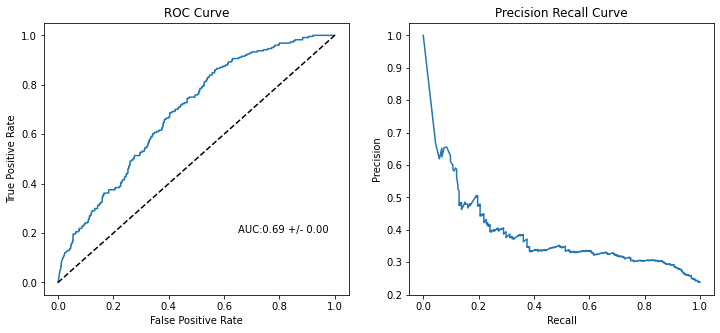

In [160]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))

ax.plot(results["FPR_curve"], results["TPR_curve"])
    
ax.plot([0,1],[0,1], c = "black", linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

ax.text(0.65, 0.2, "AUC:{:.2f} +/- {:.2f}".format(results["AUC"].mean(), results["AUC"].std()))

ax2.plot(results["rec_curve"], results["prec_curve"])
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve');

#fig.savefig(os.path.join(file_place, "ROC_scores.png"), bbox_inches = 'tight')

In [167]:
results["F1"]

0.4450867052023122

TypeError: unhashable type: 'list'

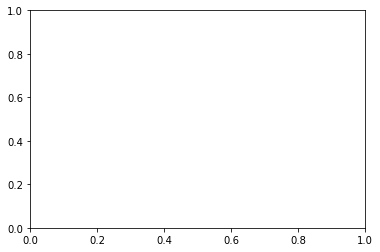

In [162]:
fig, ax = plt.subplots(ncols = 1)

results[["AUC", "Specificity", "Sensitivity", "Precision", "Recall", "F1"]].plot.box(ax = ax)
ax.set_ylabel("Score");

#results.to_excel(os.path.join(file_place, "Confusion_Matrix_bad.xlsx"))
#fig.savefig(os.path.join(file_place, "scores.png"), bbox_inches = 'tight')

In [156]:
results

{'FPR_curve': array([0.        , 0.0064433 , 0.01030928, 0.01030928, 0.01159794,
        0.01159794, 0.0128866 , 0.01675258, 0.01804124, 0.02061856,
        0.02190722, 0.02319588, 0.02319588, 0.02448454, 0.02706186,
        0.03092784, 0.03221649, 0.03479381, 0.03737113, 0.03865979,
        0.04123711, 0.04123711, 0.04252577, 0.04252577, 0.04639175,
        0.04639175, 0.04768041, 0.05025773, 0.05283505, 0.05283505,
        0.05412371, 0.05412371, 0.05541237, 0.05541237, 0.06314433,
        0.06314433, 0.06443299, 0.06443299, 0.07474227, 0.07474227,
        0.07603093, 0.07603093, 0.07731959, 0.07731959, 0.08634021,
        0.08634021, 0.09149485, 0.09149485, 0.09536082, 0.09536082,
        0.09793814, 0.09793814, 0.10695876, 0.10695876, 0.10953608,
        0.10953608, 0.1121134 , 0.1121134 , 0.11340206, 0.11340206,
        0.11597938, 0.11597938, 0.11984536, 0.11984536, 0.12113402,
        0.12242268, 0.12242268, 0.13273196, 0.13273196, 0.14304124,
        0.14304124, 0.14948454, 0.1

In [ ]:
data = total_.copy().sample(frac = 1)
breast_data = truncate(breast_DF.copy().sample(frac = 1))

In [61]:
data.head()

998.0   \
2year 5year Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Diagnosis Age DiedvsAlive ECS ID      N stage OUTCOME    Overall Death  Pathogical Stage Patient nu  Patient_Number T stage TMA TMA site Tissue advancing front type diff envi_loc                                           gender lifespan radiotherapy recurrence survival (months)             
False False /mnt/b/Google_Drive/PhD/Project with Janet/Labe... F10    F10    FOM                      Other      51.0          Alive       no  1.0-F10 2b      alive      no             pT2N2bM0         3302        3302           2       1.0 F10      Tumour dyscohesive          well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      NaT      yes          no         46.0               0.025185   
            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... A12    A12    FOM                      Other      61.0          Alive       yes 1.0-A12 1       alive      no             pT4N1M0          3252        3252           4       1.0 A12      Tumour cords/islands        mod  /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      NaT      yes          no         123.0              0.086267   
            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... E11    E11    oral tongue              Other      68.0          Alive       no  1.0-E11 1       alive      no             pT2N1            3585        3585           2       1.0 E11      Tumour non-cohesive         mod  /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      NaT      yes          no         60.0               0.025047   
True  False /mnt/b/Google_Drive/PhD/Project with Janet/Labe... B1     B1     oral tongue              DOD        70.0          Died        yes 2.0-B1  1       DOD        yes            pT4N1M0          3251        3251           4       2.0 B1       Tumour islands              mod  /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      51 days  no           no         2.0                0.045037   
            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... G13    G13    oral tongue              Other      53.0          Died        yes 2.0-G13 2b      died other yes            pT3N2bMx         3480        3480           3       2.0 G13      Tumour dyscohesive          mod  /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      504 days yes          NaN        18.0               0.091499   

                                                                                                                                                                                                                                                                                                                                                                                                           1002.0  \
2year 5year Annotation_loc                                     Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Diagnosis Age DiedvsAlive ECS ID      N stage OUTCOME    Overall Death  Pathogical Stage Patient nu  Patient_Number T stage TMA TMA site Tissue advancing front type diff envi_loc                                           gender lifespan radiotherapy recurrence survival (months)             
False False /mnt/b/Google_Drive/PhD/Project with Janet/Labe... F10    F10    FOM                      Other      51.0          Alive       no  1.0-F10 2b      alive      no             pT2N2bM0         3302        3302           2       1.0 F10      Tumour dyscohesive          well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m      NaT      yes          no         46.0               0.026133   
            /mnt/b/Google_Drive/PhD/Project with Janet/Labe... A12    A12    FOM                      Other      61.0          Alive       yes 1.0-A12 1       alive      no             pT4N1M0          3252        3252           4       1.0 A12      Tumour cords/islands        mod  /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f      NaT

In [ ]:
ldapipe.fit(X_train, y_train_b.values.squeeze())
    
    scores = dict()

    for name, scorer in scoring_dict.items():
        
        scores[name] = scorer(ldapipe, X_valid, y_valid_b)
        
    results[valid_pat[0]] = scores